# Multimodal

In [1]:
import sys
sys.path.append('../')

In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
from ELD.utils import circle_size, colors, toImg, preprocess
from ELD.model import loadMultiModalFan#, predict_landmarks
from torchgeometry.contrib import spatial_soft_argmax2d
from glob import glob
import tifffile as tiff

/home/markus.ekvall/anaconda3/envs/ELD/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def load_imgs(path):
    #get files with glob
    files = glob(f"{path}*")
    #sort files by number
    

    mod0, mod1 = [], []
    for f in files:
        if "mod0" in f:
            mod0.append(f)
        elif "mod1" in f:
            mod1.append(f)
    
    #load images
    if mod0[0].endswith('.tif'):
        mod0 = [tiff.imread(f) for f in mod0]
    else:
        mod0 = [cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) for f in mod0]

    #load images
    if mod1[0].endswith('.tif'):
        mod1 = [tiff.imread(f) for f in mod1]
    else:
        mod1 = [cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) for f in mod1]


    return mod0, mod1


In [4]:
#You can download the dataset from here: https://figshare.com/projects/ELD/167318

In [5]:
#set your path here
PATH = "/data/ekvall/marcoAnalysis/"

## Developing Heart

In [6]:
inpath = f'{PATH}dev_heart_mixed/'

In [7]:
#load imgs and move to tensor
mod0,mod1 = load_imgs(inpath)
mod0 = torch.stack([preprocess(img) for img in mod0])
mod1 = torch.stack([preprocess(img) for img in mod1])


You can can either train a model with:

```
python train.py --elastic_sigma 3.5 --cuda 0 --port 9100 --data_path ../marcoAnalysis/CODA_prostate/ --npts 20 --o scratch --ws 10_000 --angle 10 --model 3d
```

Or download a test model at: https://figshare.com/projects/ELD/167318


In [8]:
#load model
fan = loadMultiModalFan(npoints=20,n_channels=3,path_to_model="../models/multimodal/dev_heart/model_40.fan.pth")

In [9]:
def make_mask(img, is_true=True):
    print(is_true)
    if is_true:
        return torch.ones(img.shape[0], dtype=torch.bool)
    else:
        return torch.zeros(img.shape[0], dtype=torch.bool)
    


def predict_landmarks(fan, image, ismod0=True):
    with torch.no_grad():
   
        fan.eval()

        with torch.no_grad():
            pts = 4 * spatial_soft_argmax2d(fan(image.cuda(), make_mask(image, ismod0).cuda())[0], False)
    return pts
        

In [10]:
#predict landmarks
pts_mod0 = predict_landmarks(fan, mod0, ismod0=True)
pts_mod1 = predict_landmarks(fan, mod1, ismod0=False)
#combine landmarks and image
#np_img = toImg(image.cuda()[:,:3], pts, 128)
np_mod0 = toImg(mod0.cuda()[:,:3], pts_mod0, 128)
np_mod1 = toImg(mod1.cuda()[:,:3], pts_mod1, 128)


True
False


In [11]:
images = np.concatenate([np_mod0, np_mod1], axis=0)

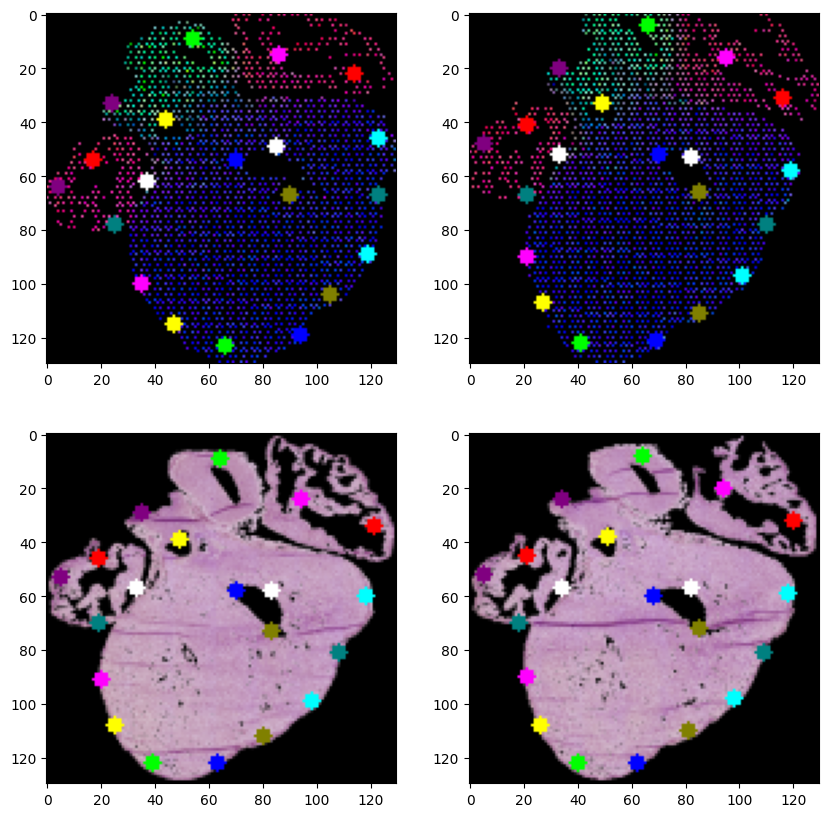

In [12]:
#plot 4 images images
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].imshow(images[0])
ax[0,1].imshow(images[1])
ax[1,0].imshow(images[2])
ax[1,1].imshow(images[3])


## SMA

In [13]:
inpath = f'{PATH}SMA_multi_modal_expression/'

In [14]:
#load imgs and move to tensor
mod0,mod1 = load_imgs(inpath)
mod0 = torch.stack([preprocess(img) for img in mod0])
mod1 = torch.stack([preprocess(img) for img in mod1])


In [15]:
!ls ../Exp_24

ls: cannot access '../Exp_24': No such file or directory


In [16]:
fan = loadMultiModalFan(npoints=10,n_channels=3,path_to_model="../models/multimodal/sma/model_10.fan.pth")

In [17]:
#predict landmarks
pts_mod0 = predict_landmarks(fan, mod0, ismod0=True)
pts_mod1 = predict_landmarks(fan, mod1, ismod0=False)
np_mod0 = toImg(mod0.cuda()[:,:3], pts_mod0, 128)
np_mod1 = toImg(mod1.cuda()[:,:3], pts_mod1, 128)


True
False


In [18]:
images = np.concatenate([np_mod0, np_mod1], axis=0)

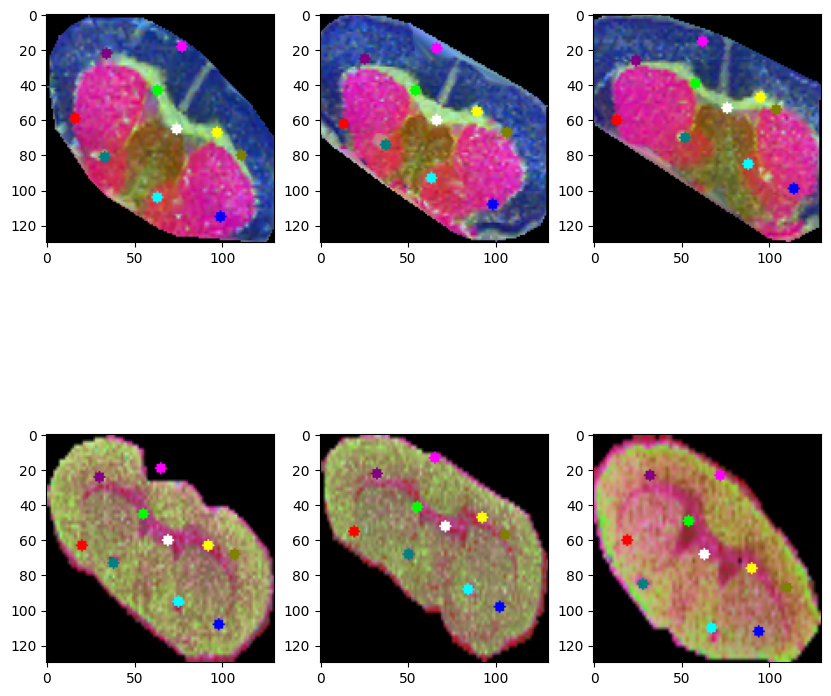

In [19]:
#plot 6 imgs images

fig, ax = plt.subplots(2,3, figsize=(10,10))
ax[0,0].imshow(images[0])
ax[0,1].imshow(images[1])
ax[0,2].imshow(images[2])
ax[1,0].imshow(images[3])
ax[1,1].imshow(images[5])
ax[1,2].imshow(images[4])
